Running Source Test...

===== TEST RESULT: SOURCE (0nm test) =====
Loss: 0.1763
Accuracy: 0.9600
              precision    recall  f1-score   support

        Bpfi       1.00      1.00      1.00       441
        Bpfo       1.00      1.00      1.00       448
    Misalign       1.00      1.00      1.00       892
      Normal       0.92      0.94      0.93      1098
   Unbalance       0.93      0.91      0.92       946

    accuracy                           0.96      3825
   macro avg       0.97      0.97      0.97      3825
weighted avg       0.96      0.96      0.96      3825



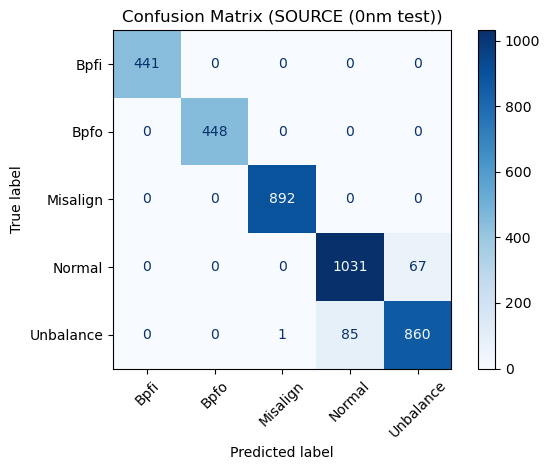

Running Target Test...

===== TEST RESULT: TARGET (2nm normal+fault) =====
Loss: 1.3543
Accuracy: 0.5686
              precision    recall  f1-score   support

        Bpfi       0.27      1.00      0.43      3000
        Bpfo       1.00      1.00      1.00      3000
    Misalign       1.00      0.75      0.86      6000
      Normal       0.00      0.00      0.00       450
   Unbalance       0.00      0.00      0.00      6000

    accuracy                           0.57     18450
   macro avg       0.45      0.55      0.46     18450
weighted avg       0.53      0.57      0.51     18450



c:\Users\Cuong\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Cuong\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Cuong\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

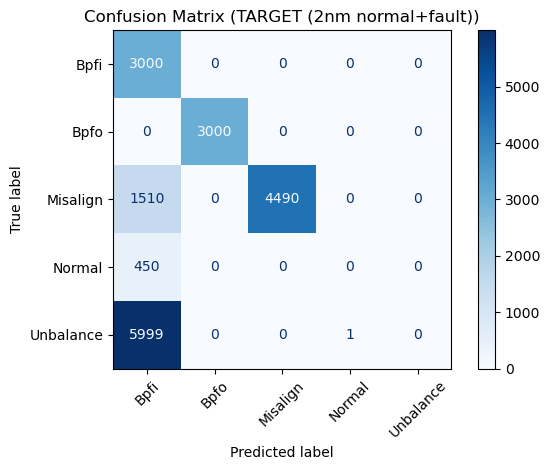


============= SUMMARY =============
Source Test Accuracy: 0.9600
Target Test Accuracy: 0.5686


In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from PrepareData.DataLoader import (
    source_test_loader,
    target_test_loader
)

from Backbone.CNN1D import CNN1D
from Backbone.CNN2D import CNN2D

# ============================
# CONFIG
# ============================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
Fourier_transform = "STFT"   # phải giống lúc train
MODEL_PATH = "best_model.pth"

# Lấy số lớp từ dataloader
NUM_CLASSES = len(source_test_loader.dataset.labels)
CLASS_NAMES = source_test_loader.dataset.labels


# ============================
# LOAD MODEL
# ============================
model = CNN2D(NUM_CLASSES) if Fourier_transform == "STFT" else CNN1D(NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True))
model.to(DEVICE)
model.eval()

criterion = nn.CrossEntropyLoss()


# ============================
# TEST FUNCTION
# ============================
def test_model(model, loader, domain_name="unknown"):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y, d in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)

            logits, _ = model(x)
            loss = criterion(logits, y)

            total_loss += loss.item() * y.size(0)
            total_correct += (logits.argmax(1) == y).sum().item()
            total_samples += y.size(0)

            all_preds.extend(logits.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / total_samples
    avg_acc  = total_correct / total_samples

    print(f"\n===== TEST RESULT: {domain_name} =====")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {avg_acc:.4f}")
    print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

    # === Confusion Matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Confusion Matrix ({domain_name})")
    plt.tight_layout()
    plt.show()

    return avg_loss, avg_acc


# ============================
# RUN TESTS
# ============================
print("Running Source Test...")
source_loss, source_acc = test_model(model, source_test_loader, domain_name="SOURCE (0nm test)")

print("Running Target Test...")
target_loss, target_acc = test_model(model, target_test_loader, domain_name="TARGET (2nm normal+fault)")


print("\n============= SUMMARY =============")
print(f"Source Test Accuracy: {source_acc:.4f}")
print(f"Target Test Accuracy: {target_acc:.4f}")
print("===================================")


d:\lt\datn\cnn transfer\PrepareData\DataLoader.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seg = torch.tensor(seg, dtype=torch.float32)



===== SOURCE TEST RESULTS =====
Source Test Loss: 0.0265
Source Test Acc : 0.9895

===== TARGET TEST RESULTS =====
Target Test Loss: 0.8143
Target Test Acc : 0.7330


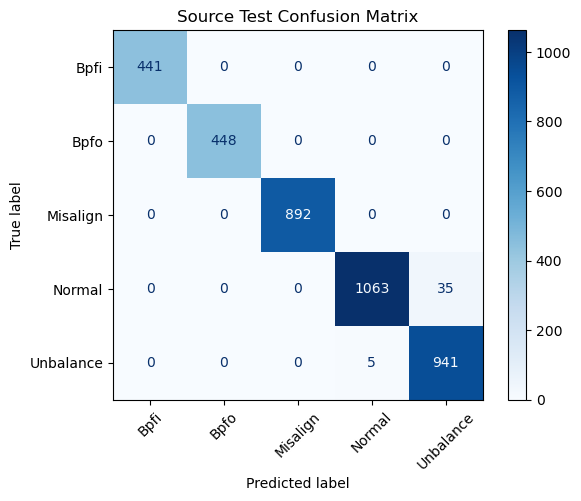

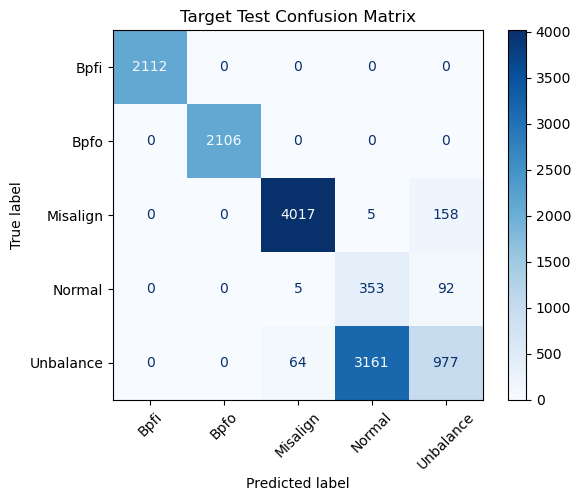


Testing complete.


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- project imports ---
from PrepareData.DataLoader import (
    source_test_loader,
    target_test_loader
)
from PrepareData.SignalSegments import LABEL_TO_IDX
from Backbone.CNN1D import CNN1D
from Backbone.CNN2D import CNN2D

# =========================
# CONFIG
# =========================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
FOURIER = "STFT"                      # "FFT" hoặc "STFT"
MODEL_PATH = "best_model.pth"
NUM_CLASSES = len(LABEL_TO_IDX)

# =========================
# LOAD MODEL
# =========================
model = (CNN2D(NUM_CLASSES) if FOURIER == "STFT" else CNN1D(NUM_CLASSES)).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True))
model.eval()

criterion = nn.CrossEntropyLoss()

# =======================================================
# Evaluation function (returns loss, acc, all_preds, all_labels)
# =======================================================
def evaluate(loader):
    model.eval()
    total_loss = 0
    total = 0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y, d in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits, _ = model(x)

            loss = criterion(logits, y)
            total_loss += loss.item() * y.size(0)

            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc, all_preds, all_labels


# =======================================================
# SOURCE TEST
# =======================================================
src_loss, src_acc, src_preds, src_labels = evaluate(source_test_loader)
print("\n===== SOURCE TEST RESULTS =====")
print(f"Source Test Loss: {src_loss:.4f}")
print(f"Source Test Acc : {src_acc:.4f}")


# =======================================================
# TARGET TEST
# =======================================================
tgt_loss, tgt_acc, tgt_preds, tgt_labels = evaluate(target_test_loader)
print("\n===== TARGET TEST RESULTS =====")
print(f"Target Test Loss: {tgt_loss:.4f}")
print(f"Target Test Acc : {tgt_acc:.4f}")


# =======================================================
# Confusion Matrix Helper
# =======================================================
IDX_TO_LABEL = {v: k for k, v in LABEL_TO_IDX.items()}

def plot_conf_mat(y_true, y_pred, title="Confusion Matrix"):
    labels = list(LABEL_TO_IDX.values())
    disp = ConfusionMatrixDisplay(
        confusion_matrix(y_true, y_pred, labels=labels),
        display_labels=[IDX_TO_LABEL[i] for i in labels]
    )
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()


# =======================================================
# Plot source confusion matrix
# =======================================================
plot_conf_mat(src_labels, src_preds, title="Source Test Confusion Matrix")

# =======================================================
# Plot target confusion matrix
# =======================================================
plot_conf_mat(tgt_labels, tgt_preds, title="Target Test Confusion Matrix")

print("\nTesting complete.")
